# Growthcleanr Data Exploration Tool

## Background

As stated in [Automated identification of implausible values in growth data from pediatric electronic health records](https://academic.oup.com/jamia/article/24/6/1080/3767271):

> In pediatrics, evaluation of growth is fundamental, and many pediatric research studies include some aspect of growth as an outcome or other variable. The clinical growth measurements obtained in day-to-day care are susceptible to error beyond the imprecision inherent in any anthropometric measurement. Some errors result from minor problems with measurement technique. While these errors can be important in certain analyses, they are often small and generally impossible to detect after measurements are recorded. Larger measurement technique errors can result in values that are biologically implausible and can cause problems for many analyses. 

## Growthcleanr

[growthcleanr](https://github.com/carriedaymont/growthcleanr) is an automated method for cleaning longitudinal pediatric growth data from EHRs. It is available as open source software.

## Data Exploration Tool

The objective of this tool is to allow users to analyze how growthcleanr is performing on a data set. This tool is to be used **after** a data set has been run through growthcleanr.

This tool is a [Juypter Notebook](https://jupyter.org/). It provides an environment that includes graphical user interfaces as well as interactive software development to explore data. This notebook uses the [Python programming language](https://www.python.org/). The Python code is used to import, transform, visualize and analyze the output of growthcleanr. Some of the code for the tool is directly included in this notebook. Other functions have been placed in an external file to minimize the amount of code that users see in order to let them focus on the actual data.

Data analysis is performed using [NumPy](https://numpy.org/) and [Pandas](https://pandas.pydata.org/). The output of growthcleanr will be loaded into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). This tool expects the output to be in a [CSV format that is described later on in the notebook](#input_structure). This tool provides functions for transforming DataFrames to support calculation of some values, such as BMI, as well as supporting visualizations. It is expected that users will create views into or copies of the DataFrames built initially by this tool. Adding columns to the DataFrames created by this tool is unlikely to cause problems. Removing columns is likely to break some of the tool's functionality.

Visualization in the tool is provided by [Matplotlib](https://matplotlib.org/) and [Seaborn](http://seaborn.pydata.org/). Users may generate their own charts with these utilities.

---

Jupyter Notebooks have documentation cells, such as this one, and code cells like the one below. The notebook server can runs the code and provides results (if applicable) back in the notebook. The following code cell loads the libraries necessary for the tool to work. If you would like to incorporate other Python libraries to assist in data exploration, they can be added here. Removing libraries from this cell will very likely break the tool.

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
from IPython.display import FileLink, FileLinks

The next two code cells tell the notebook server to automatically reload the externally defined Python functions created to assist in data analysis.

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

This code cell instructs the notebook to display plots automatically inline

In [24]:
%matplotlib inline

This code cell tells the notebook to output plots for high DPI displays, such as 4K monitors, many smartphones or a retina display on Apple hardware. This cell does not need to be run and can be safely removed. If removed, charts will look more "blocky" or "pixelated" on high DPI displays.

In [5]:
%config InlineBackend.figure_format = 'retina'

The following cell import functions created for the tool to asssist in data analysis. Some of the functions generate charts used in this tool. The chart code may be modified to change the appearance of plots without too much risk of breaking things. Other functions transform DataFrames and changing those will very likely cause things to break. If you are unable to tell the difference in the functions by looking at the code, it is probably best to leave them unmodified.

In [6]:
import charts

This cell reads in a data set that has been run through the [growthcleanr](https://github.com/carriedaymont/growthcleanr) algorithm. Details of the algorithm can be found in [Automated identification of implausible values in growth data from pediatric electronic health records](https://academic.oup.com/jamia/article/24/6/1080/3767271)

<a id="input_structure"></a>
Data is expected to be in a CSV file with the following structure:

| Column | Description |
|--------|-------------|
| id | A unique identifier for an observation |
| subjid | An identifier for the individual from which the observation was obtained |
| sex | A numeric value of 0 (male) or 1 (female). Note that this differs from the CDC Growth Chart Data Tables. |
| agedays | Number representing the age of the patient in days when the observation was obtained |
| param | The type of observation along with units. Expected values are *HEIGHTCM* and *WEIGHTKG* |
| measurement | A decimal number that represents the observation value. |
| clean_value | The categorization of the observation by growthcleanr. |

This information will be loaded into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) called `cleaned_obs`

In [7]:
cleaned_obs = pd.read_csv("clean.csv")

The following cell shows what the first five rows look like in the CSV file

In [25]:
cleaned_obs.head()

,id,subjid,sex,agedays,param,measurement,clean_value,clean_cat,age,include,height,weight
0,1,46663895,0,2970,HEIGHTCM,121.920000,Include,Include,8.136986,True,121.92,NaN
1,2,46663895,0,3776,HEIGHTCM,152.400000,Include,Include,10.345205,True,152.40,NaN
2,3,46663895,0,2970,WEIGHTKG,24.494239,Include,Include,8.136986,True,NaN,24.494239
3,4,46663895,0,3776,WEIGHTKG,40.823732,Include,Include,10.345205,True,NaN,40.823732
4,5,46668331,0,2959,HEIGHTCM,116.840000,Include,Include,8.106849,True,116.84,NaN


Next, the `charts.setup_individual_obs_df` function performs transformations on the `cleaned_obs` DataFrame. This will create an `age` column, which is a decimal column that represents the patient's age in years at the time of the observation. It changes the `clean_value` column into a [pandas categorical type](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html). It also create an `include` column which contains a boolean value indicating whether growthcleanr states to include (true) or exclude (false) the observation. The resulting DataFrame is assigned to `obs`.

In [26]:
obs = charts.setup_individual_obs_df(cleaned_obs)

The following cell loads in the [CDC Growth Chart Percentile Data Files](https://www.cdc.gov/growthcharts/percentile_data_files.htm). Functions coerce some values into numeric types. It also add an `age` column which is a decimal value representing age in years. Finally, `Sex` is transformed so that the values align with the values used in growthcleanr, 0 (male) or 1 (female). This data is used to plot percentile bands in visualizations in the tool. 

In [9]:
bmi_percentiles = pd.read_csv("bmiagerev.csv")
bmi_percentiles = charts.setup_percentiles(bmi_percentiles)
wt_percentiles = pd.read_csv("wtage.csv")
wt_percentiles = charts.setup_percentiles(wt_percentiles)
ht_percentiles = pd.read_csv("statage.csv")
ht_percentiles = charts.setup_percentiles(ht_percentiles)

In a previous cell, the tool creates the `obs` DataFrame. In that structure there is one measurement, either height or weight, per row. In this cell, the `charts.setup_merged_df` function will create a DataFrame where a height observation and weight observation for the same `subjid` on the same `agedays` are combined into a single row. Several new columns are added to the resulting DataFrame:

| Column | Description |
|--------|-------------|
| weight | The `measurement` value for observations that had the `param` of *WEIGHTKG* |
| height | The `measurement` value for observations that had the `param` of *HEIGHTCM* |
| bmi | The BMI calculated from `weight` and `height` |
| weight_cat | The value previously stored in `clean_value` for the weight observation |
| include_weight | The value previously stored in `include` for the weight observation |
| height_cat | The value previously stored in `clean_value` for the height observation |
| include_height | The value previously stored in `include` for the height observation |
| include_both | Logical AND of `include_weight` and `logical_height` |

The result is stored in `merged_df`.

In [27]:
merged_df = charts.setup_merged_df(obs)

This next cell creates interactive tool can be used to explore patients. The `charts.top_ten` function will create a DataFrame showing the 10 items from the passed in `merged_df` based on the passed in selection criteria. The selection criteria are determined by interacting with the generated user interface. The tool uses [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) to create the user interface.

In [29]:
age_options = widgets.IntRangeSlider(value=[2, 20], min=2, max=20, step=1, description='Age:', 
                                     continuous_update=False,
                                     orientation='horizontal', readout=True, readout_format='d')

exclusion_options = []
for c in cleaned_obs.clean_cat.unique():
  exclusion_options.append((c, c))
exclusion_values = [x[1] for x in exclusion_options] 

weight_exclusions = widgets.SelectMultiple(options=exclusion_options, 
                                           value=exclusion_values, rows=17,
                                           description='Weight Exclusions')
height_exclusions = widgets.SelectMultiple(options=exclusion_values, 
                                           value=exclusion_values, rows=17,
                                           description='Height Exclusions')
field_selector = widgets.Dropdown(options=["height", "weight", "bmi"], description='Field: ')
sex_selector = widgets.Dropdown(options=[('Any', None), ('Female', 1), ('Male', 0)], description='Sex:')
order_selector = widgets.Dropdown(options=['largest', 'smallest'], description='Order:')
out = widgets.Output()

top_row = widgets.HBox([field_selector, age_options, sex_selector])
middle_row = widgets.HBox([weight_exclusions, height_exclusions])
ui = widgets.VBox([top_row, middle_row, order_selector])

widgets.interactive_output(charts.top_ten, {'merged_df': fixed(merged_df), 
                                            'field': field_selector, 
                                            'age': age_options, 
                                            'sex': sex_selector, 
                                            'wexclusion': weight_exclusions, 
                                            'hexclusion': height_exclusions, 
                                            'order': order_selector, 
                                            'out': fixed(out)})

display(ui, out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '         subjid  sex         height_ca…

It can be useful to copy values from the `subjid` column in the results above for use in visualizations in the rest of the tool.

The cell below creates a plot for an individual. It shows either the weight trajectory or height tragectory depending on the `param` value that is selected. The black bands in the diagram represent the 5th and 95th percentile values for age and sex for the given measurement type.

In this chart, the blue line represents all measurements for an individual. Any values marked for exclusion are represented with a red x. The yellow dashed line represents the trajectory with exclusions removed. Any carried forward values are represented by a blue triangle, unless `include_carry_forward` is set to False, when they will also be represented as a red x.

In [12]:
interactive(charts.overlap_view, obs_df=fixed(obs), 
            subjid=widgets.BoundedIntText(value=47085108,
                                          min=0,
                                          max=100000000,
                                          description='Subject ID:',
                                          disabled=False), 
            param=['HEIGHTCM', 'WEIGHTKG'], 
            include_carry_forward=[True, False], 
            include_percentiles=[True, False],
            wt_df=fixed(wt_percentiles), ht_df=fixed(ht_percentiles))

interactive(children=(BoundedIntText(value=47085108, description='Subject ID:', max=100000000), Dropdown(descr…

Next, the tool creates a series that contains the unique set of `subjid`s and stores that in `uniq_ids`.

In [13]:
uniq_ids = cleaned_obs['subjid'].unique()

From the series of unique ids, the following cell randonly selects 16 individuals and assigns them to `sample`.

In [20]:
sample = np.random.choice(uniq_ids, size=16)

In [21]:
sample

array([47105545, 46854984, 46814562, 46934226, 46852963, 47075509,
       46841281, 47094911, 46869932, 46742866, 46963880, 46815247,
       46952368, 46793103, 46886877, 46873371])

The `sample` can be passed into the `charts.four_by_four_view` function which will create a [small multiple](https://en.wikipedia.org/wiki/Small_multiple) plot for each of the individuals. Exclusions, including carry forwards, will be represented by a red x.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

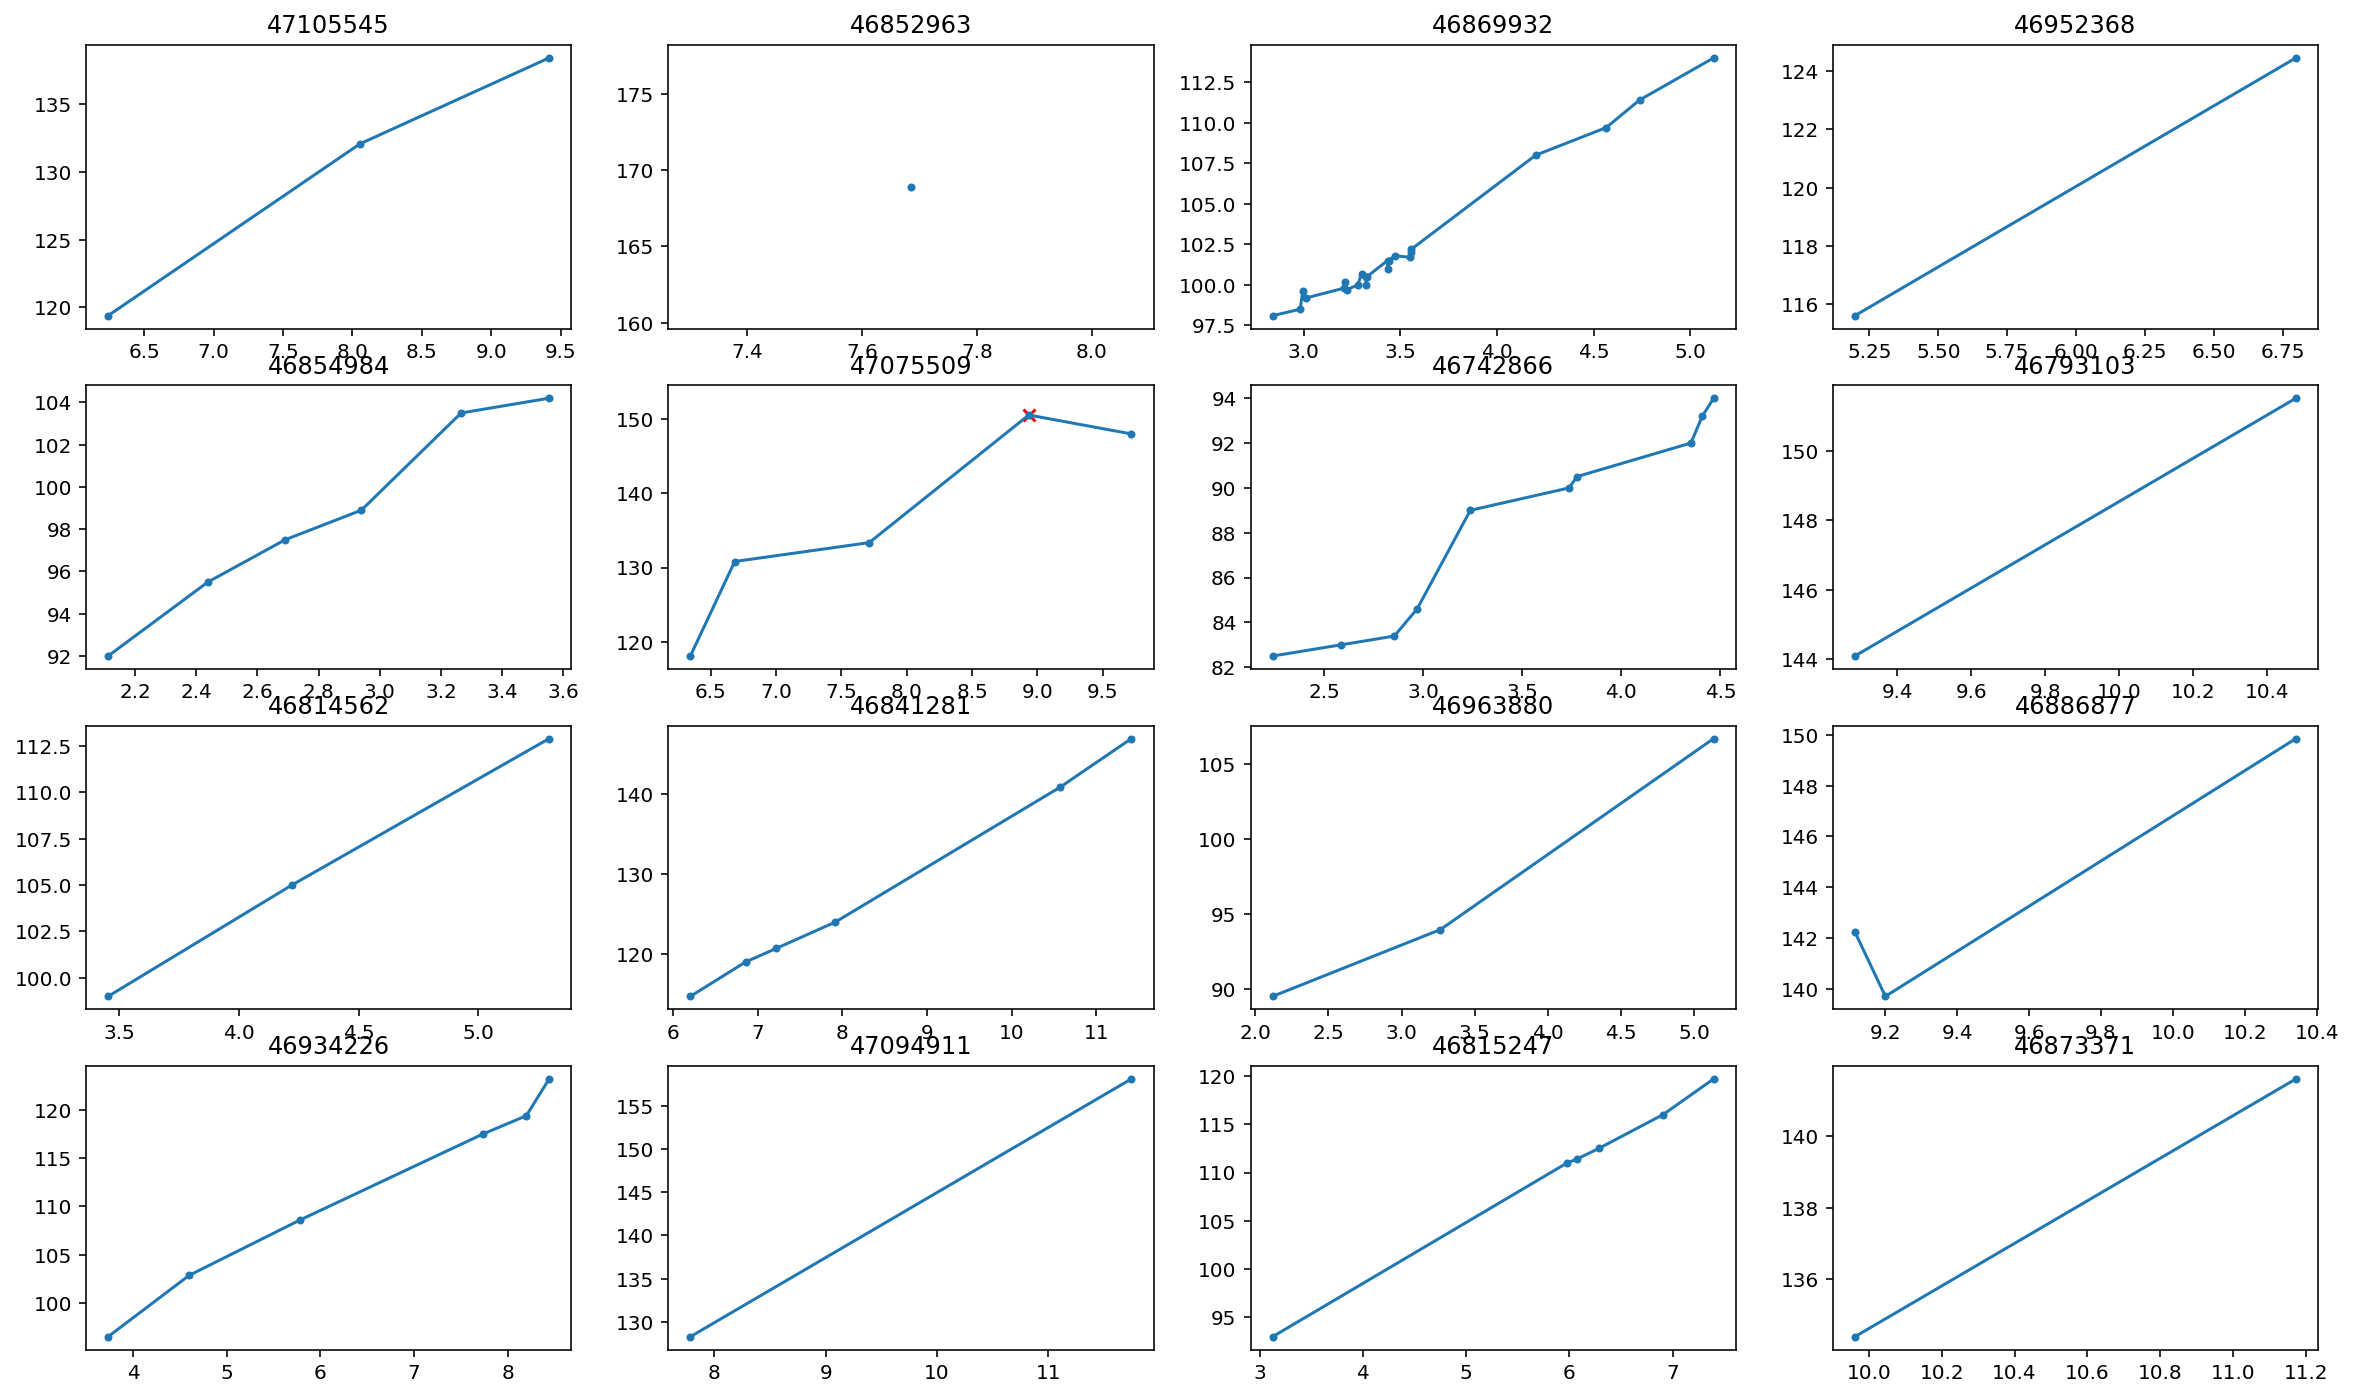

In [23]:
charts.four_by_four_view(cleaned_obs, sample, 'HEIGHTCM')

The `charts.bmi_with_percentiles` function displays a chart showing BMI for an individual over time. Black bands representing the 5th and 95th BMI percentile for age and sex are shown with the individual's BMI shown in blue. The plot on the left represents all values. The plot on the right is only included values.

In [17]:
interact(charts.bmi_with_percentiles, merged_df = fixed(merged_df), 
                                      bmi_percentiles = fixed(bmi_percentiles),
                                      subjid = widgets.BoundedIntText(value=46717134,
                                                                      min=0,
                                                                      max=100000000,
                                                                      description='Subject ID:',
                                                                      disabled=False
))

interactive(children=(BoundedIntText(value=46717134, description='Subject ID:', max=100000000), Output()), _do…

<function charts.bmi_with_percentiles(merged_df, bmi_percentiles, subjid)>

The next cell generates summary statistics for the data set. The `charts.bmi_stats` function uses the `merged_df` DataFrame to compute values on the "clean" data, which means only included values as well as the "raw" values, which is all values for individuals.

The buttons can be used to add or remove columns from the table.

In [18]:
min_toggle = widgets.ToggleButton(value=True, description='Minimum BMI')
mean_toggle = widgets.ToggleButton(value=True, description='Mean BMI')
max_toggle = widgets.ToggleButton(value=True, description='Maximum BMI')
std_toggle = widgets.ToggleButton(value=True, description='BMI Standard Deviation')
med_toggle = widgets.ToggleButton(value=True, description='Median BMI')
count_toggle = widgets.ToggleButton(value=True, description='Count')
diff_toggle = widgets.ToggleButton(value=True, description='Mean BMI Difference')
age_range = widgets.IntRangeSlider(value=[2, 20], min=2, max=20, step=1, description='Age:', continuous_update=False,
                                   orientation='horizontal', readout=True, readout_format='d')
hbox = widgets.HBox([min_toggle, mean_toggle, max_toggle, std_toggle, med_toggle, count_toggle, diff_toggle])
ui = widgets.VBox([age_range, hbox])
out = widgets.Output()
widgets.interactive_output(charts.bmi_stats, {'merged_df': fixed(merged_df), 'include_min': min_toggle, 
         'include_mean': mean_toggle, 'include_max': max_toggle, 'include_std': std_toggle, 
         'include_median': med_toggle, 'include_mean_diff': diff_toggle, 'include_count': count_toggle,
         'out': fixed(out), 'age_range': age_range})
display(ui, out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<pandas.io.formats.style.Styler at 0x1…

The following code allows you to export a DataFrame as a CSV file. When the cell below is run, the drop down will contain all DataFrames stored in variables in this notebook. Select the desired DataFrame and click Generate CSV. This will create the CSV file and provide a link to download it.

In [19]:
df_selector = widgets.Dropdown(options=charts.data_frame_names(locals()), description='Data Frames')
generate_button = widgets.Button(description='Generate CSV')
ui = widgets.VBox([df_selector, generate_button])
out = widgets.Output()

l = locals()
def on_button_clicked(b):
    charts.export_to_csv(l, df_selector, out)

generate_button.on_click(on_button_clicked)
    
display(ui, out)

Output()